## preparation and initialisation

In [1]:
# loading libraries 
import networkx as nx                         # for network stuff
import numpy as np                            # 
from matplotlib import pyplot as plt  
import pandas as pd
import random

# intitialising graph
adj_matrix = pd.read_csv('/home/dot/random_coding/modeling_article/synthetic_edges.csv', index_col= 0 )
#print(adj_matrix)
adj_matrix.columns = adj_matrix.columns.astype(int)
G = nx.from_pandas_adjacency(adj_matrix)

# adding social support
nodes = pd.read_csv('/home/dot/random_coding/modeling_article/synthetic_nodes.csv')
soc_sup_dict = dict(zip(nodes['ID'], nodes['SOC_SUP']))
nx.set_node_attributes(G, soc_sup_dict, "social_support")

# rescale to 0-1
for n in G.nodes():
    if "social_support" in G.nodes[n]:
        G.nodes[n]["social_support"] /= 10.0

## initial checks to see if everything looks as it should

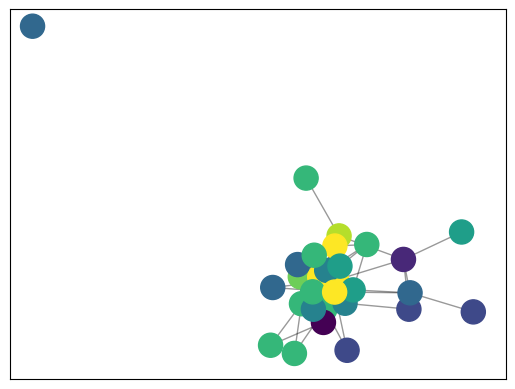

In [2]:
# preliminary visualisation
soc_sup = nx.get_node_attributes(G, "social_support")
node_colors = [soc_sup[node] for node in G.nodes()]
pos = nx.spring_layout(G, seed=42)

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    cmap=plt.cm.viridis,   # heatmap-style colormap
    node_size=300
)

nx.draw_networkx_edges(G, pos, alpha=0.4)
# social support average and distribution

Average degree: 6.827586206896552
Min degree: 0
Max degree: 15
density: 0.2438423645320197
average clustering: 0.4712553729795109


(array([1., 3., 5., 0., 0., 2., 2., 0., 0., 3., 2., 0., 0., 4., 2., 0., 1.,
        2., 0., 2.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 <BarContainer object of 20 artists>)

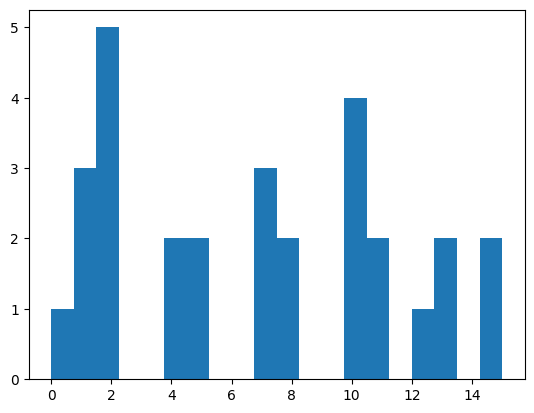

In [3]:
# network statistics
degrees = dict(G.degree())
deg_values = np.array(list(degrees.values()))

print(f"Average degree: {deg_values.mean()}")
print(f"Min degree: {deg_values.min()}")
print(f"Max degree: {deg_values.max()}")
print(f"density: {nx.density(G)}")
print(f"average clustering: {nx.average_clustering(G)}")

#degree distribution:
plt.hist(deg_values, bins=20)

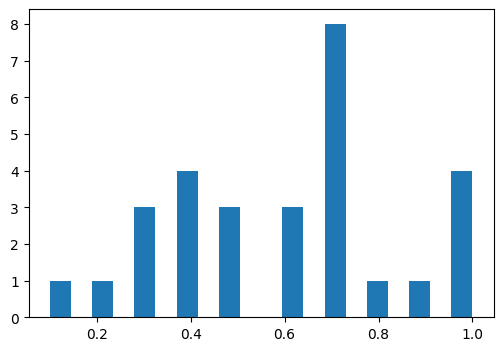

In [4]:
# social support: 
soc_sup = nx.get_node_attributes(G, "social_support")
soc_sup_values = np.array(list(soc_sup.values()))

plt.figure(figsize=(6, 4))
plt.hist(soc_sup_values, bins=20)
plt.show()

## Agent Based Model

In [5]:
# initialise each node as agent (with individual level variables)
for n in G.nodes():    
    G.nodes[n]["individual_resilience"] = np.clip(
        np.random.normal(loc= 0.05, scale=0.3), -1, 1
    ) #mean = 0, stddev = 0.3 scale bound by -1 and 1
    
    G.nodes[n]["social_support"] = soc_sup[n]  

# define and initialise variables at group level (resilience, internal social support)
G.graph["internal_social_support"] = 0.2
G.graph["group_resilience"] = 0.05
G.graph["causes_of_burnout"] = 0.05

In [6]:
# parameters
dt = 0.01                          # time scale
repression_resilience = -0.6           # repression effect on resilience
repression_burnout = 0.01          # effect of repression on other causes of burnout
external_support_weight = 0.4     # external social support effect on individual resilience
internal_support_weight = 0.2      # internal social support effect on micro and meso resilience
support_feedback_weight = 0.07      # weight of the feedback between internal social support and micro/meso resilience
causes_burnout_weight = -0.01      # negative feedback from causes of burnout
resilience_burnout = -0.2          # effect of resilience on causes of burnout
resilience_feedback_weight = 0.3   # micro meso feedback

dropout_threshold = -0.6           # resilience threshold for dropping out
base_rate = 0.217 #0.021631305164                    # base rate for new agents joining
sensitivity = 1                    # sensitivity of join probability to repression
new_agent_connections = 2          # number of connections new agents make
support_threshold = -0.2       # above which edge deletion probability > addition, and agents do not receive support over this edge anymore
edge_base_prob = 0.1          # base probability of forming an edge per timestep
edge_resilience_weight = 0.06  # weight of individual resilience in edge formation


In [7]:
# main loop
def timestep_update(G):
    nodes = list(G.nodes())
    
    # update individual resilience
    internal_support = G.graph["internal_social_support"]
    group_resilience = G.graph["group_resilience"]
    causes_burnout = G.graph["causes_of_burnout"]
    
    for n in nodes:
        external_support = G.nodes[n]["social_support"]  # this stays stable
        neighbors = list(G.neighbors(n))
        
        if neighbors:
            neighbor_resilience = np.mean(
                [G.nodes[j]["individual_resilience"] for j in neighbors]
            ) #computes the mean resilience of the neighbours of n
        else:
            neighbor_resilience = 0.0 #setting it to 0 for isolates

                
        
        r_old = G.nodes[n]["individual_resilience"]
        r_new = r_old + dt * (
            repression_resilience * G.graph["repression"]
            + external_support_weight * external_support
            + internal_support_weight * np.clip(support_threshold + neighbor_resilience, 0, 1) #internal support as function of resilience of neighbours
            + resilience_feedback_weight * group_resilience
            + causes_burnout_weight * causes_burnout
        )
        # Bound between -1 and 1
        G.nodes[n]["individual_resilience"] = np.clip(r_new, -1, 1)
    
    # 2️update group resilience
    micro_mean = np.mean([G.nodes[n]["individual_resilience"] for n in nodes])
    g_old = group_resilience
    g_new = g_old + dt *(
        repression_resilience * G.graph["repression"]
        + internal_support_weight * internal_support
        + resilience_feedback_weight * micro_mean
        + causes_burnout_weight * causes_burnout
    )
    G.graph["group_resilience"] = np.clip(g_new, -1, 1)

    #update internal social support
    G.graph["internal_social_support"] += support_feedback_weight * G.graph["group_resilience"]
    G.graph["internal_social_support"] = np.clip(G.graph["internal_social_support"], 0, 1)
    
    # update causes of burnout 
    G.graph["causes_of_burnout"] += resilience_burnout * (micro_mean + G.graph["group_resilience"]) # + repression_burnout * G.graph["repression"] # maybe include direct effect of repression on COB later
    G.graph["causes_of_burnout"] = np.clip(G.graph["causes_of_burnout"], 0, 1)
    
    # handle agents dropping out
    dropouts = [n for n in nodes if G.nodes[n]["individual_resilience"] < dropout_threshold]
    G.remove_nodes_from(dropouts)
    
    # handle agents joining 
    p_join = base_rate * int(1 + sensitivity * G.graph["repression"])
    
    if random.random() < p_join:
        new_id = max(G.nodes()) + 1 if len(G.nodes()) > 0 else 1
    
        # sample social support from existing nodes
        existing_ss = [
            G.nodes[n]["social_support"]
            for n in G.nodes()
            if "social_support" in G.nodes[n]
        ]
        new_soc_sup = 0.1 + np.random.choice(existing_ss) # add small bias for more positive social support
    
        # add node
        G.add_node(
            new_id,
            social_support=new_soc_sup,
            individual_resilience=np.clip(np.random.normal(0, 0.3), -1, 1)
        )
    
        # connect to existing nodes
        possible_targets = list(G.nodes())
        possible_targets.remove(new_id)
    
        if possible_targets:
            targets = random.sample(
                possible_targets,
                min(new_agent_connections, len(possible_targets))
            )
            for t in targets:
                G.add_edge(new_id, t)

    
    # edge updating for existing agents
    for n in G.nodes():
        neighbors = set(G.neighbors(n))
        potential_targets = set(G.nodes()) - {n} - neighbors
        # Edge deletion probability increases if individual resilience < threshold
        r_n = G.nodes[n]["individual_resilience"]
        deletion_prob = max(0, (-r_n - support_threshold))  # 0 if above threshold
        addition_prob = max(0, edge_resilience_weight * r_n + edge_base_prob) 
        # Delete edges
        for neighbor in list(neighbors):
            if random.random() < deletion_prob:
                G.remove_edge(n, neighbor)
        # Add edges
        for target in potential_targets:
            if random.random() < addition_prob:
                G.add_edge(n, target)


In [8]:
def repression_schedule(t,
                        low=0.2,
                        high=0.8,
                        t_low=10,
                        t_transition=10):
    if t < t_low:
        return low
    elif t < t_low + t_transition:
        return low + (high - low) * (t - t_low) / t_transition
    else:
        return high

In [9]:
# tracking all variables over time
history = {
    "t": [],
    "group_resilience": [],
    "mean_individual_resilience": [],
    "std_individual_resilience": [],
    "internal_social_support": [],
    "causes_of_burnout": [],
    "repression": [],
    "num_agents": [],
    "mean_external_social_support": []
}

def log_state(G, t, history):
    nodes = list(G.nodes())

    # individual resilience stats
    if nodes:
        indiv_res = [G.nodes[n]["individual_resilience"] for n in nodes]
        mean_indiv_res = np.mean(indiv_res)
        std_indiv_res = np.std(indiv_res)

        external_support = [
            G.nodes[n]["social_support"]
            for n in nodes
            if "social_support" in G.nodes[n]
        ]
        mean_external_support = np.mean(external_support) if external_support else 0.0
    else:
        mean_indiv_res = 0.0
        std_indiv_res = 0.0
        mean_external_support = 0.0

    # store
    history["t"].append(t)
    history["group_resilience"].append(G.graph["group_resilience"])
    history["mean_individual_resilience"].append(mean_indiv_res)
    history["std_individual_resilience"].append(std_indiv_res)
    history["internal_social_support"].append(G.graph["internal_social_support"])
    history["causes_of_burnout"].append(G.graph["causes_of_burnout"])
    history["repression"].append(G.graph["repression"])
    history["num_agents"].append(len(nodes))
    history["mean_external_social_support"].append(mean_external_support)


In [10]:
# running it for n timesteps:
T = 50
for t in range(T):
    G.graph["repression"] = repression_schedule(t)
    timestep_update(G)
    log_state(G, t, history)

In [11]:
print(G.graph["internal_social_support"])
print(G.graph["group_resilience"])
print(G.graph["causes_of_burnout"])  
#print(G.nodes[n]["individual_resilience"])

0.16974515540850602
-0.10444636808547414
0.20840809013910938


## visualisations

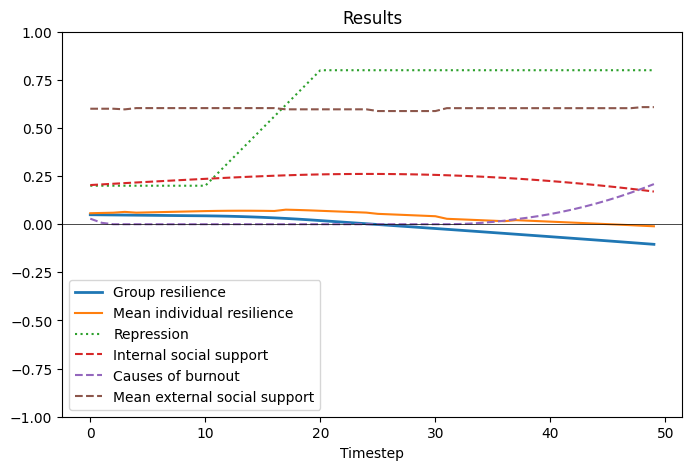

In [12]:
plt.figure(figsize=(8, 5))

plt.plot(
    history["t"],
    history["group_resilience"],
    label="Group resilience",
    linewidth=2,
    linestyle="-"
)
plt.plot(
    history["t"],
    history["mean_individual_resilience"],
    label="Mean individual resilience",
    linestyle="-"
)
plt.plot(
    history["t"],
    history["repression"],
    label="Repression",
    linestyle=":"
)
plt.plot(
    history["t"],
    history["internal_social_support"],
    label="Internal social support",
    linestyle="--"
)
plt.plot(
    history["t"],
    history["causes_of_burnout"],
    label="Causes of burnout",
    linestyle="--"
)
plt.plot(
    history["t"],
    history["mean_external_social_support"],
    label="Mean external social support",
    linestyle="--"
)

plt.axhline(0, color="black", linewidth=0.5)
plt.ylim(-1, 1)         
plt.xlabel("Timestep")
plt.legend()
plt.title("Results")
plt.show()



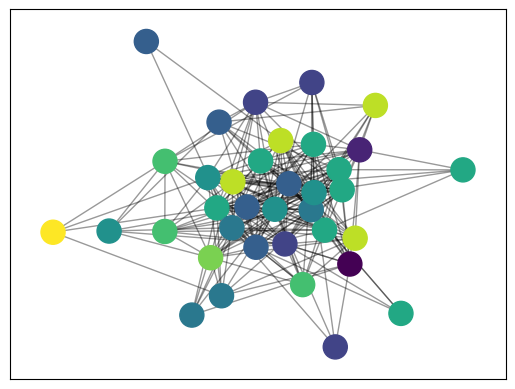

In [13]:
# visualisation to check outcome
soc_sup = nx.get_node_attributes(G, "social_support")
node_colors = [soc_sup[node] for node in G.nodes()]
pos = nx.spring_layout(G, seed=42)

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    cmap=plt.cm.viridis,   # heatmap-style colormap
    node_size=300
)

nx.draw_networkx_edges(G, pos, alpha=0.4)

Number of nodes: 36
Average degree: 13.61111111111111
Min degree: 2
Max degree: 25
density: 0.3888888888888889
average clustering: 0.5474629798854123


(array([1., 3., 1., 2., 1., 1., 3., 2., 0., 4., 1., 2., 3., 2., 3., 1., 1.,
        2., 0., 3.]),
 array([ 2.  ,  3.15,  4.3 ,  5.45,  6.6 ,  7.75,  8.9 , 10.05, 11.2 ,
        12.35, 13.5 , 14.65, 15.8 , 16.95, 18.1 , 19.25, 20.4 , 21.55,
        22.7 , 23.85, 25.  ]),
 <BarContainer object of 20 artists>)

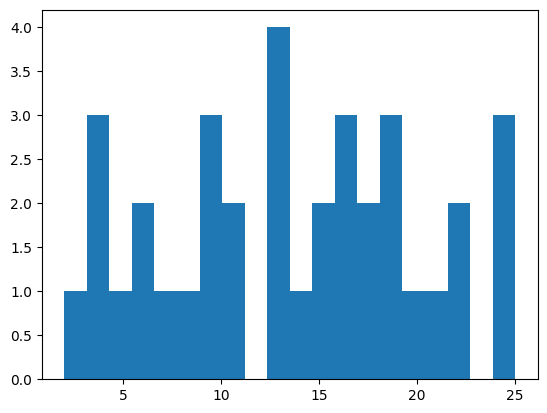

In [14]:
# network statistics
degrees = dict(G.degree())
deg_values = np.array(list(degrees.values()))

print(f"Number of nodes: {nx.number_of_nodes(G)}")
print(f"Average degree: {deg_values.mean()}")
print(f"Min degree: {deg_values.min()}")
print(f"Max degree: {deg_values.max()}")
print(f"density: {nx.density(G)}")
print(f"average clustering: {nx.average_clustering(G)}")

#degree distribution:
plt.hist(deg_values, bins=20)